---------------------
---------------------
---------------------
---------------------
-----------------------------------


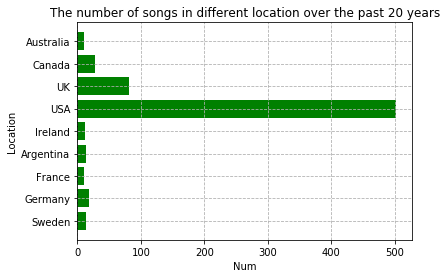

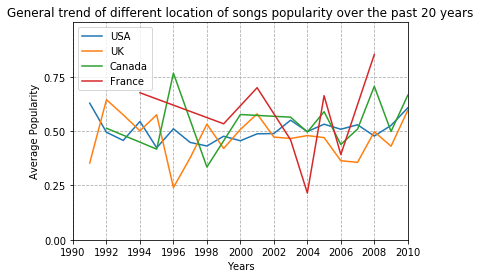

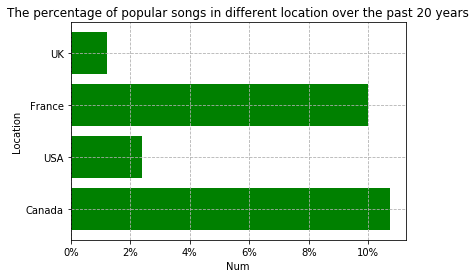

In [6]:
from pyspark import SparkContext, SparkConf
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
import pyspark.sql.functions as f
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from collections import Counter
from matplotlib.ticker import FuncFormatter

spark = SparkSession.builder.appName('MSD').getOrCreate()

df = spark.read.format("parquet").options(inferSchema=True).load("hdfs:/user/yxl13-kkr16/CleanedSongDataset1.parquet")

df1 = df.select('ArtistLocation', 'Year').filter(df['Year'] > 1990)

location_list = []
size = df1.select(df1.ArtistLocation).dropDuplicates().count()
for i in range(0, size):
    location2 = df1.select(df1.ArtistLocation).dropDuplicates().collect()[i][0]
    location_list.append(location2)
#print(location_list)
#print('-----------------------------------')

num = []
for i in range(0, len(location_list)):
    val = df1.filter(df1.ArtistLocation == location_list[i]).count()
    num.append(val)

#print(num)
#print('-----------------------------------')
d = dict(zip(location_list, num))

# print(d)

new_location = []
new_num = []
for k, v in d.items():
    if v < 10:
        continue
    new_location.append(k)
    new_num.append(v)

# print(new_num)
# print(new_location)


fig, ax = plt.subplots()
ax.barh(new_location, new_num, color='green')
ax.grid(ls='--')
ax.title.set_text(r'The number of songs in different location over the past 20 years')
ax.set_xlabel("Num")
ax.set_ylabel("Location")


# print('-----------------------------------------------------------------')

df1 = df.select('ArtistLocation', 'Popularity', 'Year').filter(df.Year > 1990)


def analysis(target):
    df2 = df1.select("Popularity", 'Year').filter(df.ArtistLocation == target)
    print('---------------------')

    size = df2.select(df2.Year).count()  # number of songs created in the past 20 years
    years = []
    for i in range(0, size):
        year = df2.select("Year").collect()[i][0]
        years.append(year)
#     print(len(years))

    unique_years = set(years)
    unique_years = list(unique_years)
    unique_years.sort()

    # print(df.filter(df.Year > 2000).count())
#     print("---------------------------------------")

    def meananalysis(one_years):
        listtarget = []

        for i in range(0, len(one_years)):
            oneyeartarget = df2.select("Popularity").filter(df.Year == one_years[i])
            # print("For year:", unique_years[i])
            listtarget.append([one_years[i]])
            sum = 0
            for j in range(0, oneyeartarget.count()):
                field_value = oneyeartarget.collect()[j][0]
                sum += field_value
                # print(year_tempos)
            mean = sum / oneyeartarget.count()
            listtarget[i].append(mean)

        listtarget = dict(listtarget)
#         print(listtarget)
        return listtarget

    a = meananalysis(unique_years)
    return a


usa_popularity = analysis("USA")
uk_popularity = analysis("UK")
canada_popularity = analysis("Canada")
france_popularity = analysis("France")

fig1 = plt.figure().add_subplot(111)
fig1.plot(usa_popularity.keys(), usa_popularity.values(), label='USA')
fig1.plot(uk_popularity.keys(), uk_popularity.values(), label='UK')
fig1.plot(canada_popularity.keys(), canada_popularity.values(), label='Canada')
fig1.plot(france_popularity.keys(),france_popularity.values(), label='France')
fig1.title.set_text(r'General trend of different location of songs popularity over the past 20 years')
fig1.set_xlabel('Years')
fig1.set_ylabel('Average Popularity')
fig1.set_ylim(0.2, 1)
fig1.set_yticks(np.arange(0, 1, 0.25))
fig1.set_xlim(1990, 2010)
fig1.grid(ls='--')
fig1.set_xticks(np.arange(1990, 2012, 2))
plt.legend()

print('-----------------------------------')

df1 = df.select('ArtistLocation', 'Popularity').filter(df['Year'] > 1990)

df2 = df1.select('ArtistLocation').filter(df.Popularity >= 0.8)

size20 = df2.select('ArtistLocation').count()  # number of songs created in the past 20 years
location20_num = []
for i in range(0, size20):
    location1 = df2.select("ArtistLocation").collect()[i][0]
    location20_num.append(location1)

result20 = Counter(location20_num)
e = dict(result20)
# print(e)

location = []
num = []
for k, v in e.items():
    location.append(k)
    num.append(v)

num_percen = []
for i in range(0, len(num)):
    for k, v in d.items():
        if location[i] == k:
            a = (num[i]/v)*10
            num_percen.append(a)

# print(num_percen)

fig2 = plt.figure().add_subplot(111)
fig2.barh(location, num_percen, color='green')
fig2.grid(ls='--')
fig2.title.set_text(r'The percentage of popular songs in different location over the past 20 years')
fig2.set_xlabel("Num")
fig2.set_ylabel("Location")

def to_percent(temp, position):
    return '%1.0f' % (10*temp) + '%'


plt.gca().xaxis.set_major_formatter(FuncFormatter(to_percent))

plt.show()